<a href="https://colab.research.google.com/github/superbat3/port_fleet/blob/main/project_unsupervised_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Load the unlabeled dataset
#Dataset can be downloaded at-https://drive.google.com/file/d/1VNpBWpmw161vAoTvLsgQBvvmYlCOM3UC/view?usp=sharing
df = pd.read_csv("/content/drive/MyDrive/network_dataset.csv")
df.head()

,timestamp,bandwidth,throughput,congestion,packet_loss,latency,jitter,Routers,Planned route,Network measure,Network target,Video target,Percentage video occupancy,Bitrate video,Number videos
0,2024-05-11 12:00:15,2,2.15,0.38,0.0,6.58,0.52,up xrv6,Best effort,S1,S2,NaN,0,0,0
1,2024-05-11 12:00:43,2,2.16,0.12,0.0,5.36,0.34,up xrv6,Best effort,S1,S2,NaN,0,0,0
2,2024-05-11 12:01:12,2,2.00,0.08,0.0,6.29,0.23,up xrv6,Best effort,S1,S2,NaN,0,0,0
3,2024-05-11 12:01:40,2,2.07,0.07,0.0,5.91,0.51,up xrv6,Best effort,S1,S2,NaN,0,0,0
4,2024-05-11 12:02:08,2,2.40,0.08,0.0,5.81,0.71,up xrv6,Best effort,S1,S2,NaN,0,0,0


In [ ]:
categorical_columns=df.select_dtypes(exclude=[np.number]).columns
numeric_columns=df.select_dtypes(include=[np.number]).columns
imputer_categorical= SimpleImputer(strategy='most_frequent')
df[categorical_columns]=imputer_categorical.fit_transform(df[categorical_columns])
imputer_numeric=SimpleImputer(strategy='median')
df[numeric_columns]=imputer_numeric.fit_transform(df[numeric_columns])
df.isnull().sum()

,0
timestamp,0
bandwidth,0
throughput,0
congestion,0
packet_loss,0
latency,0
jitter,0
Routers,0
Planned route,0
Network measure,0


In [ ]:
label_encoder=LabelEncoder()
for column in categorical_columns:
  df[column] = label_encoder.fit_transform(df[column])

df.head()

,timestamp,bandwidth,throughput,congestion,packet_loss,latency,jitter,Routers,Planned route,Network measure,Network target,Video target,Percentage video occupancy,Bitrate video,Number videos
0,0,2.0,2.15,0.38,0.0,6.58,0.52,1,0,0,0,1,0.0,0.0,0.0
1,1,2.0,2.16,0.12,0.0,5.36,0.34,1,0,0,0,1,0.0,0.0,0.0
2,2,2.0,2.00,0.08,0.0,6.29,0.23,1,0,0,0,1,0.0,0.0,0.0
3,3,2.0,2.07,0.07,0.0,5.91,0.51,1,0,0,0,1,0.0,0.0,0.0
4,4,2.0,2.40,0.08,0.0,5.81,0.71,1,0,0,0,1,0.0,0.0,0.0


In [ ]:
# Combine both numerical and label-encoded categorical columns
all_features = df[numeric_columns.tolist() + categorical_columns.tolist()].values
indices = np.arange(len(df))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

X_train, X_test = all_features[train_indices], all_features[test_indices]
X_val = all_features[val_indices]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

df.head()

,timestamp,bandwidth,throughput,congestion,packet_loss,latency,jitter,Routers,Planned route,Network measure,Network target,Video target,Percentage video occupancy,Bitrate video,Number videos
0,0,2.0,2.15,0.38,0.0,6.58,0.52,1,0,0,0,1,0.0,0.0,0.0
1,1,2.0,2.16,0.12,0.0,5.36,0.34,1,0,0,0,1,0.0,0.0,0.0
2,2,2.0,2.00,0.08,0.0,6.29,0.23,1,0,0,0,1,0.0,0.0,0.0
3,3,2.0,2.07,0.07,0.0,5.91,0.51,1,0,0,0,1,0.0,0.0,0.0
4,4,2.0,2.40,0.08,0.0,5.81,0.71,1,0,0,0,1,0.0,0.0,0.0


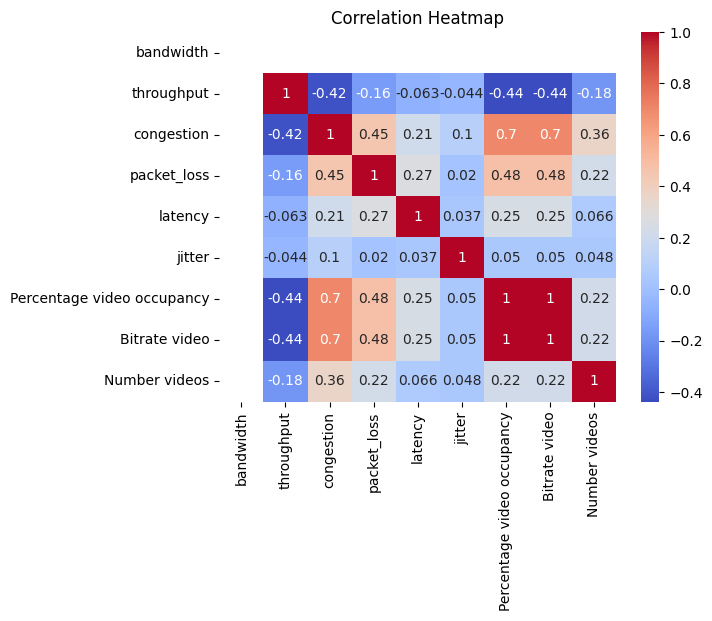

In [ ]:
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
print(f"X_train_tensor - Shape: {X_train_tensor.shape}, Data type: {X_train_tensor.dtype}, Device: {X_train_tensor.device}")
print(f"X_val_tensor - Shape: {X_val_tensor.shape}, Data type: {X_val_tensor.dtype}, Device: {X_val_tensor.device}")
print(f"X_test_tensor - Shape: {X_test_tensor.shape}, Data type: {X_test_tensor.dtype}, Device: {X_test_tensor.device}")

X_train_tensor - Shape: torch.Size([600, 15]), Data type: torch.float32, Device: cpu
X_val_tensor - Shape: torch.Size([200, 15]), Data type: torch.float32, Device: cpu
X_test_tensor - Shape: torch.Size([201, 15]), Data type: torch.float32, Device: cpu


In [ ]:
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = TensorDataset(X_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
class VariableAutoencoder(nn.Module):
  def __init__(self, input_dim, hidden_dim =400, latent_dim =200, device=device):
    super(VariableAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, latent_dim),
        nn.LeakyReLU(0.2)
    )
    self.mean_layer = nn.Linear(latent_dim, latent_dim)
    self.logvar_layer = nn.Linear(latent_dim, latent_dim)
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid()
    )
  def encode(self,x):
      x = self.encoder(x)
      mean, logvar = self.mean_layer(x), self.logvar_layer(x)
      return mean, logvar

  def reparameterize(self, mean, logvar):
    epsilon = torch.randn_like(logvar).to(device)
    return mean + torch.exp(0.5 * logvar) * epsilon

  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    x_hat = self.decode(z)
    return x_hat, mean, logvar

def loss_function(x, x_hat, mean, logvar):
  MSE = F.mse_loss(x_hat, x.view(-1, x_hat.shape[1]), reduction='sum') # Use x_hat.shape[1] for reshaping
  KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  return KLD + MSE

In [ ]:
def train_vae(model, optimizer, loss_function, train_loader, val_loader, test_loader, epochs, device):
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for batch_idx, (x_batch,) in enumerate(train_loader):
            x_batch = x_batch.to(device)
            optimizer.zero_grad()

            x_hat, mean, logvar = model(x_batch)

            loss = loss_function(x_batch, x_hat, mean, logvar)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

        train_losses[epoch] = total_train_loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            for batch_idx, (x_batch,) in enumerate(val_loader):
                x_batch = x_batch.to(device)
                x_hat, mean, logvar = model(x_batch)
                batch_loss = loss_function(x_batch, x_hat, mean, logvar)
                total_val_loss += batch_loss.item()

            val_losses[epoch] = total_val_loss / len(val_loader)


        with torch.no_grad():
            total_test_loss = 0.0
            for batch_idx, (x_batch,) in enumerate(test_loader):
                x_batch = x_batch.to(device)
                x_hat, mean, logvar = model(x_batch)

                batch_loss = loss_function(x_batch, x_hat, mean, logvar)
                total_test_loss += batch_loss.item()

            test_losses[epoch] = total_test_loss / len(test_loader)

    return train_losses, val_losses, test_losses


 VAE Final Average Training Loss over 100 epochs: 95.43577356414796
 VAE Final Average Validation Loss over 100 epochs: 92.32064470214846
 VAE Final Average Test Loss over 100 epochs: 96.58324092388152


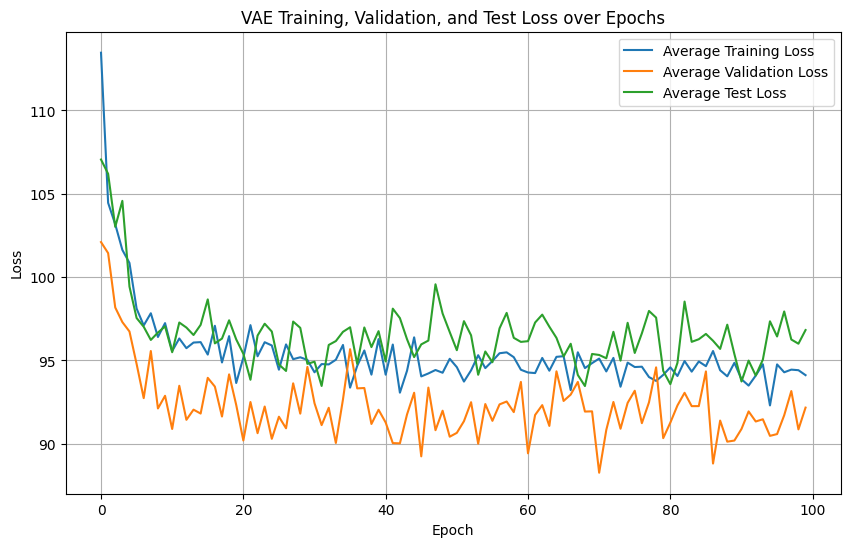

In [ ]:
VAE = VariableAutoencoder(input_dim=X_train_scaled.shape[1]).to(device)
optimizer = optim.Adam(VAE.parameters(), lr=0.001)
epochs = 100
train_losses, val_losses, test_losses = train_vae(VAE, optimizer, loss_function, train_loader, val_loader, test_loader, epochs, device)

print(f"\n VAE Final Average Training Loss over {epochs} epochs: {np.mean(train_losses)}")
print(f" VAE Final Average Validation Loss over {epochs} epochs: {np.mean(val_losses)}")
print(f" VAE Final Average Test Loss over {epochs} epochs: {np.mean(test_losses)}")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Average Training Loss')
plt.plot(val_losses, label='Average Validation Loss')
plt.plot(test_losses, label='Average Test Loss')
plt.title('VAE Training, Validation, and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Reconstruction error threshold for anomalies (87th percentile): 1.1202
Number of anomalies detected using reconstruction error: 32


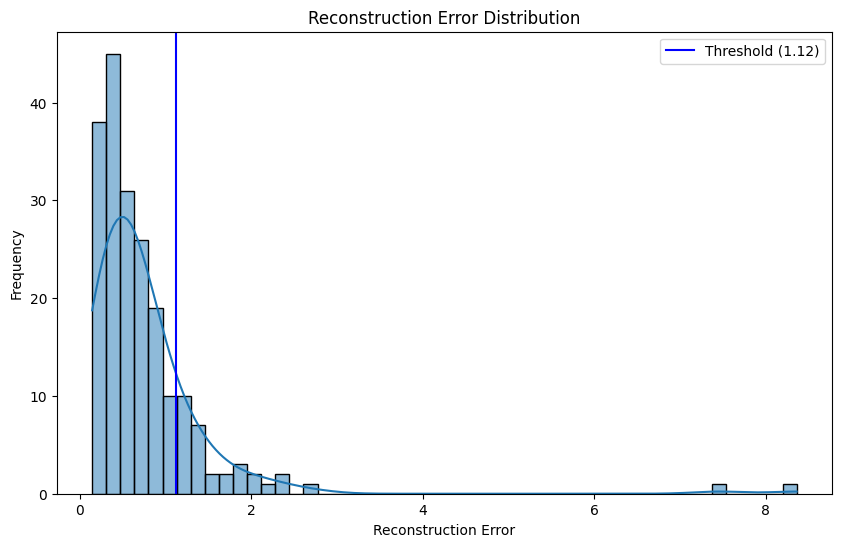

In [ ]:
VAE.eval()
reconstruction_error = []
with torch.no_grad():
  for batch_idx, (x_batch,) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    x_hat, _, _ = VAE(x_batch)

    mse_batch = F.mse_loss(x_hat, x_batch, reduction='none').mean(dim=1)
    reconstruction_error.append(mse_batch.cpu().numpy()) # Append numpy array of shape (batch_size,)

reconstruction_error = np.concatenate(reconstruction_error, axis=0)


threshold_reconstruction_error = np.percentile(reconstruction_error, 84)
print(f"Reconstruction error threshold for anomalies (87th percentile): {threshold_reconstruction_error:.4f}")

reconstruction_count = (reconstruction_error > threshold_reconstruction_error).sum()
print(f"Number of anomalies detected using reconstruction error: {reconstruction_count}")


plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(x=threshold_reconstruction_error, color="b",label=f"Threshold ({threshold_reconstruction_error:.2f})")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

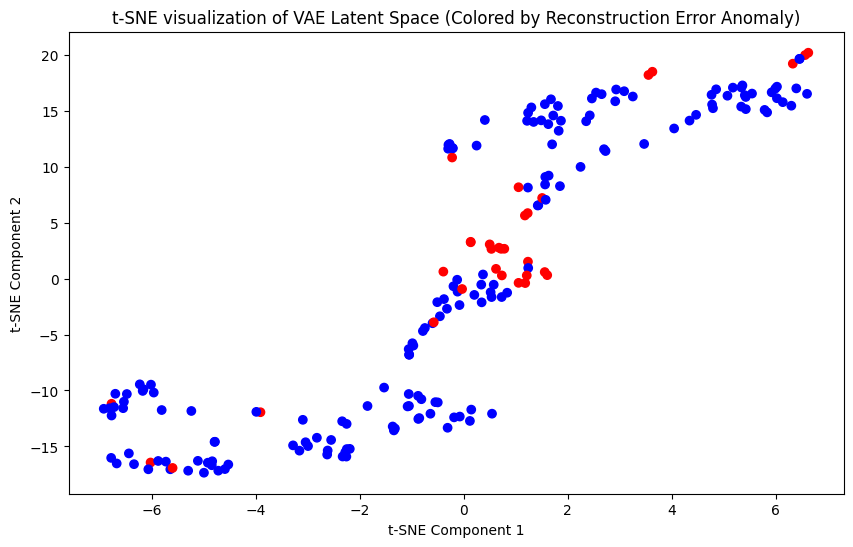

In [ ]:
from sklearn.manifold import TSNE

VAE.eval()
latent_space = []
with torch.no_grad():
  for batch_idx, (x_batch,) in enumerate(test_loader):
    x_batch = x_batch.to(device)
    mean, _ = VAE.encode(x_batch)
    latent_space.append(mean.cpu().numpy())

latent_space = np.concatenate(latent_space, axis=0)

anomaly_reconstruction = (reconstruction_error > threshold_reconstruction_error)

sne = TSNE(n_components = 2, random_state=0)
latent_2d = sne.fit_transform(latent_space)

# Define colors based on anomaly labels
colors = np.where(anomaly_reconstruction == True, 'red', 'blue')

plt.figure(figsize=(10, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors)
plt.title('t-SNE visualization of VAE Latent Space (Colored by Reconstruction Error Anomaly)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

One-Class SVM detects network anomalies, with a maximum of 10% of the training data labeled as anomalies detected totalling: 32
Percentage of test points with anomalies detected: 15.92%


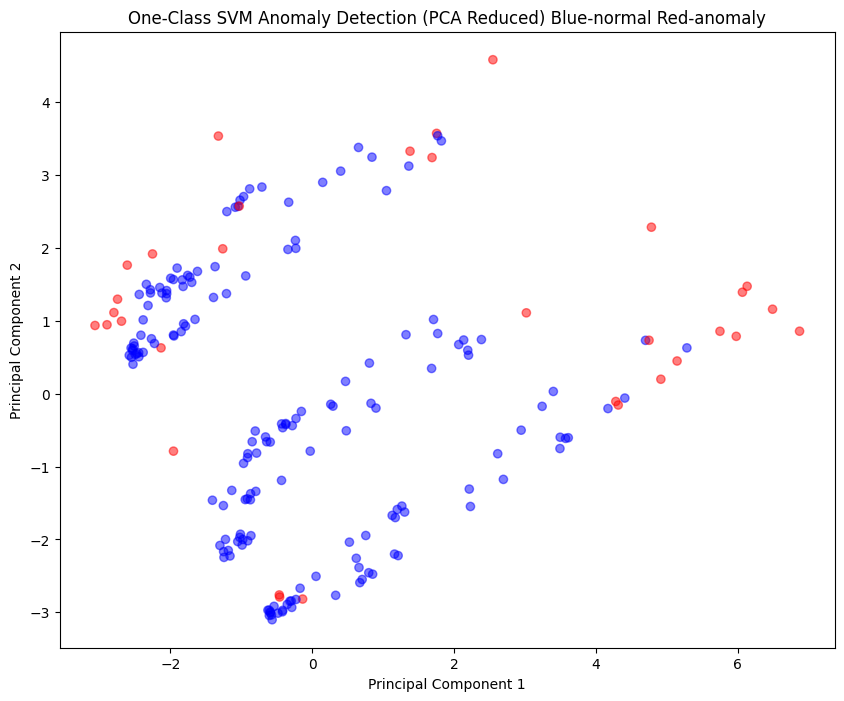

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

one_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma="auto").fit(X_train_scaled)

one_svm_anomalies = one_svm.predict(X_test_scaled)
svm_anomalies_boolean = (one_svm_anomalies == -1)
print(f"One-Class SVM detects network anomalies, with a maximum of 10% of the training data labeled as anomalies detected totalling: {svm_anomalies_boolean.sum()}")
print(f"Percentage of test points with anomalies detected: {svm_anomalies_boolean.mean() * 100:.2f}%")

pcaTest = PCA(n_components=2)
X_test_pca = pcaTest.fit_transform(X_test_scaled)
colors = np.where(svm_anomalies_boolean == True, 'red', 'blue')
plt.figure(figsize=(10, 8))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, alpha=0.5)
plt.title('One-Class SVM Anomaly Detection (PCA Reduced) Blue-normal Red-anomaly')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Get the indices of anomalies detected by VAE (based on reconstruction error threshold)
vae_anomaly_indices = np.where(reconstruction_error > threshold_reconstruction_error)[0]

# Get the indices of anomalies detected by One-Class SVM
# Remember that the One-Class SVM prediction is -1 for anomalies
one_svm_anomaly_indices = np.where(one_svm_anomalies == -1)[0]

print(f"Number of anomalies detected by VAE: {len(vae_anomaly_indices)}")
print(f"Number of anomalies detected by One-Class SVM: {len(one_svm_anomaly_indices)}")

# Find the common anomalies (detected by both)
common_anomalies_indices = np.intersect1d(vae_anomaly_indices, one_svm_anomaly_indices)
print(f"Number of anomalies detected by both VAE and One-Class SVM: {len(common_anomalies_indices)}")

# Find anomalies detected only by VAE
vae_only_anomalies_indices = np.setdiff1d(vae_anomaly_indices, one_svm_anomaly_indices)
print(f"Number of anomalies detected only by VAE: {len(vae_only_anomalies_indices)}")

# Find anomalies detected only by One-Class SVM
one_svm_only_anomalies_indices = np.setdiff1d(one_svm_anomaly_indices, vae_anomaly_indices)
print(f"Number of anomalies detected only by One-Class SVM: {len(one_svm_only_anomalies_indices)}")

# Find data points detected as normal by both
all_indices = np.arange(len(X_test_scaled))
normal_by_vae_indices = np.where(reconstruction_error <= threshold_reconstruction_error)[0]
normal_by_svm_indices = np.where(one_svm_anomalies == 1)[0]
normal_by_both_indices = np.intersect1d(normal_by_vae_indices, normal_by_svm_indices)
print(f"Number of data points detected as normal by both methods: {len(normal_by_both_indices)}")

Number of anomalies detected by VAE: 32
Number of anomalies detected by One-Class SVM: 32
Number of anomalies detected by both VAE and One-Class SVM: 23
Number of anomalies detected only by VAE: 9
Number of anomalies detected only by One-Class SVM: 9
Number of data points detected as normal by both methods: 160
